# Градиентный спуск

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.  

In [224]:
import abc

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для обучения линейной регрессии необходим функционал ошибки, определим интерфейс для последующих реализаций.

In [225]:
class BaseLoss(abc.ABC):
    """Base class for losses"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """Calculate loss value based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            number, loss value
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Calculate gradient vector based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            gradients for weights, (n_features,)
        """
        raise NotImplementedError

Вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [226]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return (np.linalg.norm(X@w - y) ** 2) / X.shape[0]

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2 * X.T @ (X@w - y) / X.shape[0]

In [227]:
# Проведем небольшую проверку реализации

# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [228]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> np.ndarray:
    """Weights optimization with gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    result = [w_init]
    for _ in range(n_iterations):
        w = result[-1]
        new_w = w - lr * loss.calc_grad(X, y, w)
        result.append(new_w)
    return result

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [229]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [230]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045025
0.8670644395649494


In [231]:
def plot_gd(w_list: np.ndarray, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """Plot gradient descent trajectory

    Args:
        w_list: weights history, (n_iterations, n_features)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

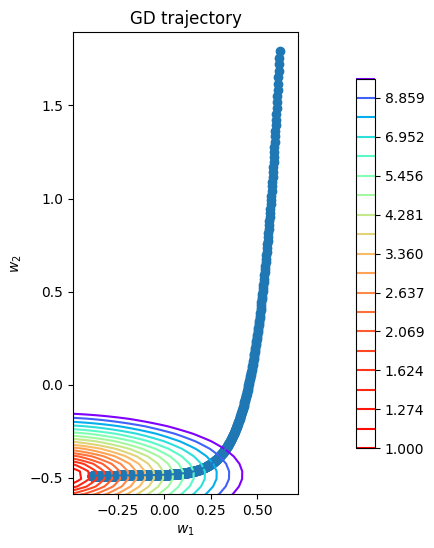

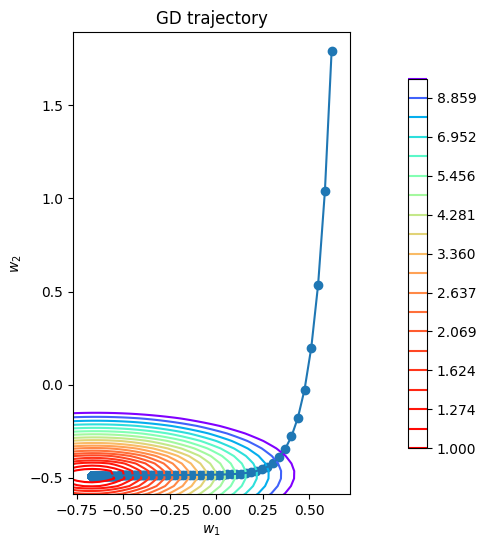

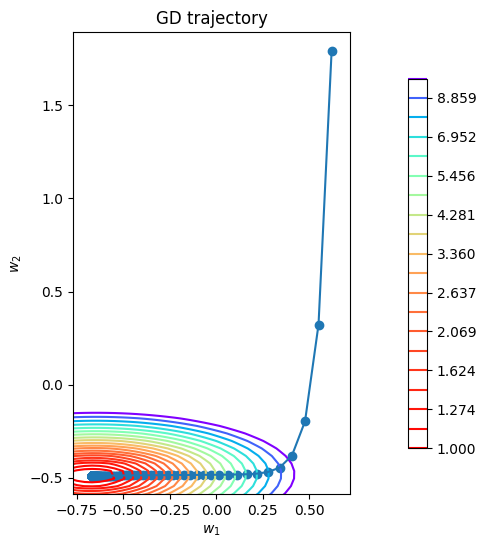

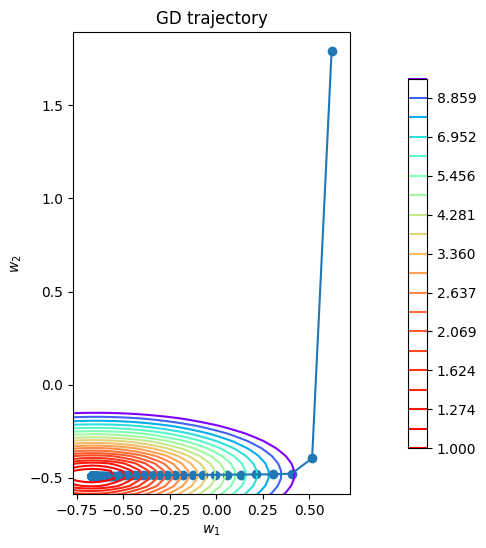

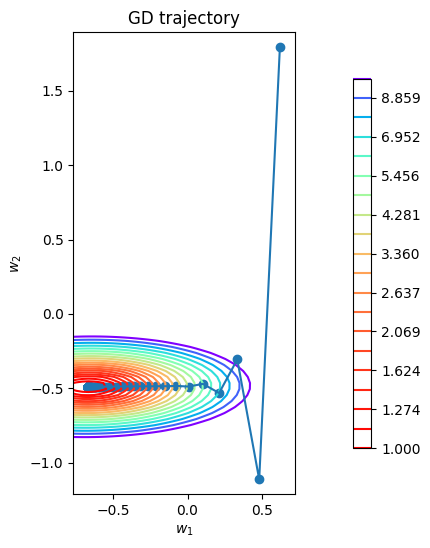

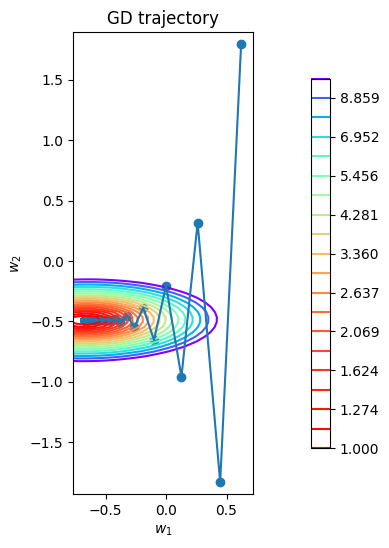

In [232]:
lr_list = np.linspace(0.0001, 0.01, 6)
loss = MSELoss()
for lr in lr_list:
    w_list = gradient_descent(w_init, X, y, loss, lr, 1000)
    plot_gd(w_list, X, y, loss)

*Меньшие значения точно приводят к искомому минимуму, но требуют большее количество итераций. Большие значения в начале промахиваются мимо нужного направления, но позже возвращаются к минимуму. В более сложном случае с большим значением шага можно проскочить минимум.*

Теперь реализуем стохастический градиентный спуск. Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [233]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with stochastic gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    result = [w_init]
    for _ in range(n_iterations):
        w = result[-1]
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        new_w = w - lr * loss.calc_grad(X[batch_indices], y[batch_indices], w)
        result.append(new_w)
    return result

При помощи функций `stochastic_gradient_descent` и `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

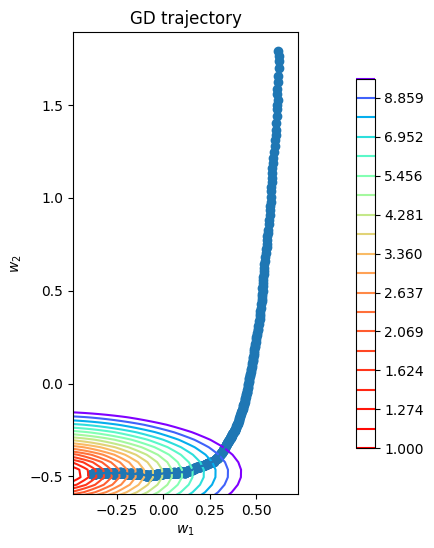

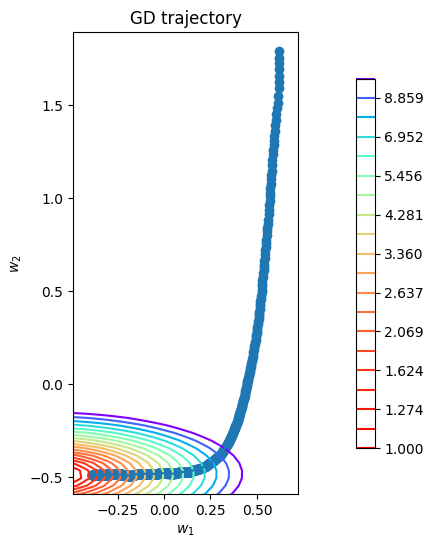

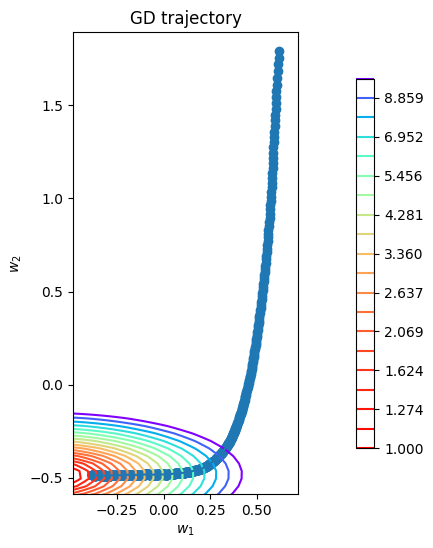

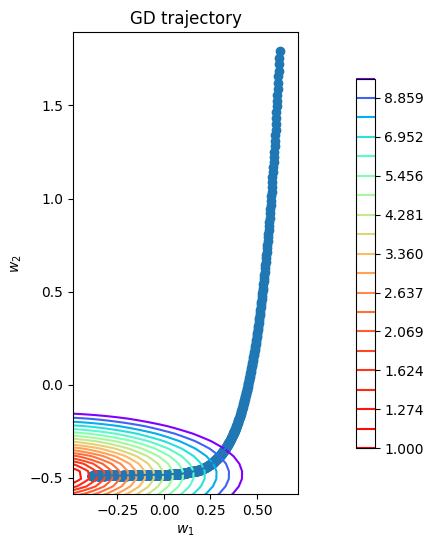

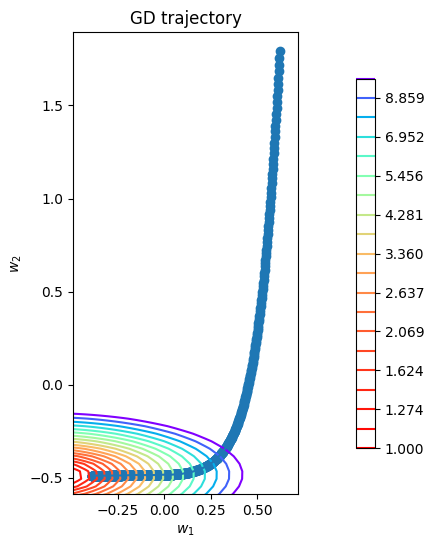

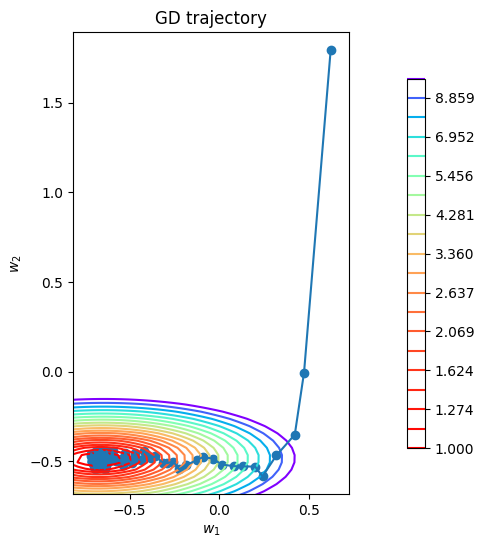

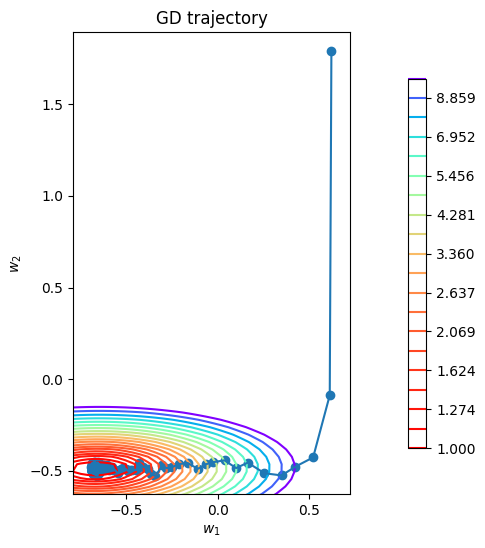

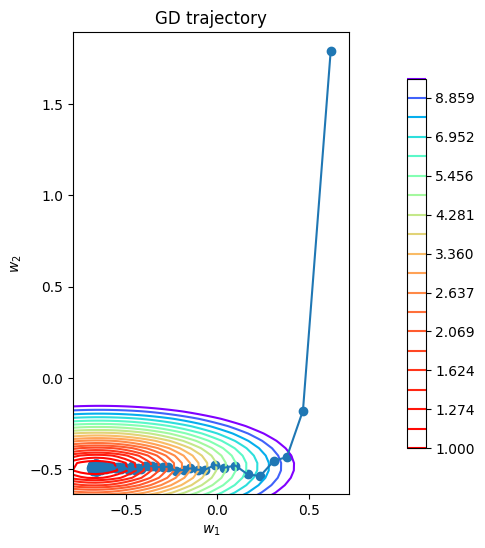

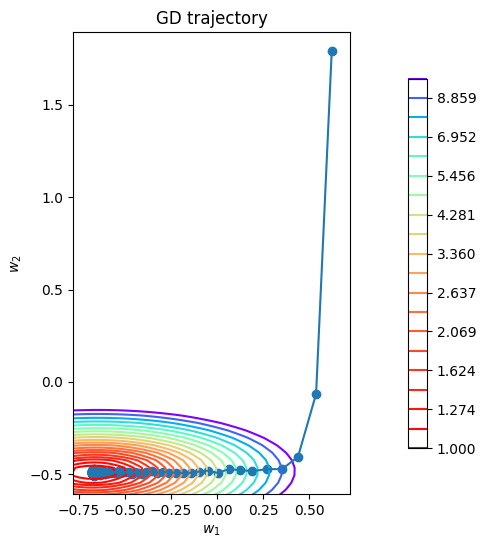

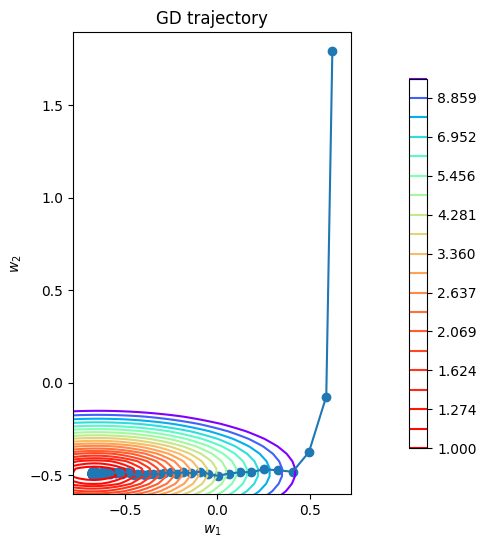

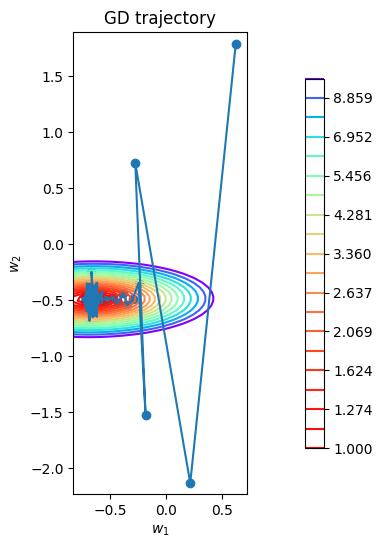

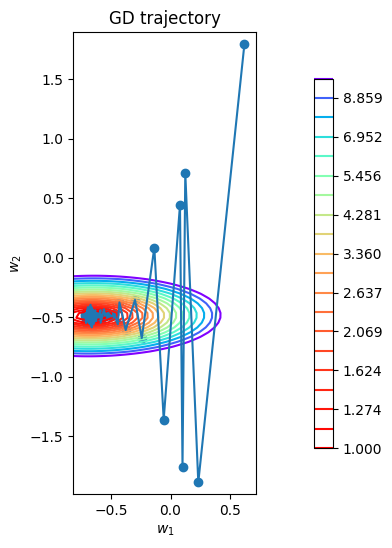

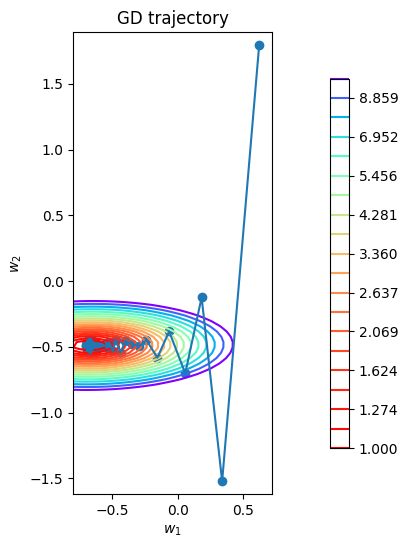

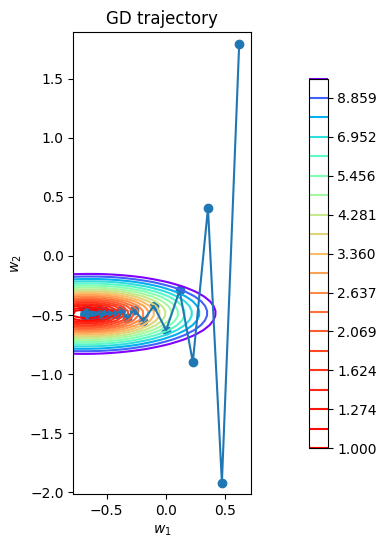

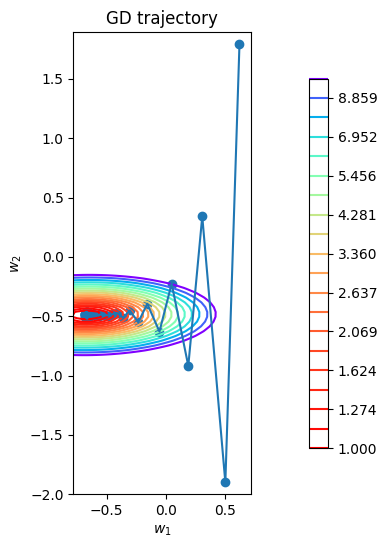

In [234]:
lr_list = np.linspace(0.0001, 0.01, 3)
loss = MSELoss()
for lr in lr_list:
    for batch_size in [20, 50, 100, 150, 200]:
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, 1000)
        plot_gd(w_list, X, y, loss)

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуйте SGD на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [235]:
def stochastic_gradient_descent_with_decay(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with SGD and learning rate decay

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        p: learning rate decay factor, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    result = [w_init]
    s_0 = 1
    for t in range(n_iterations):
        w = result[-1]
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        new_lr = lr * (s_0 / (s_0 + t)) ** p
        new_w = w - new_lr * loss.calc_grad(X[batch_indices], y[batch_indices], w)
        result.append(new_w)
    return result

При помощи новой функции `stochastic_gradient_descent_with_decay` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

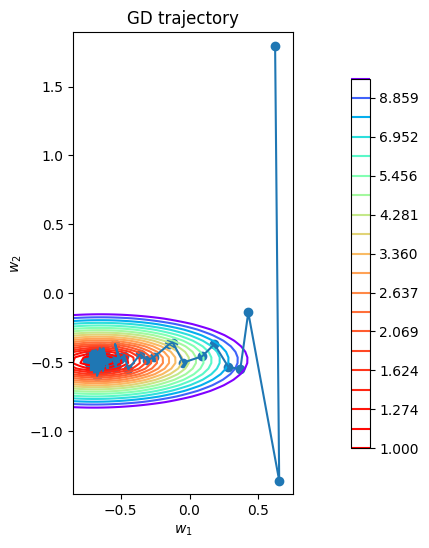

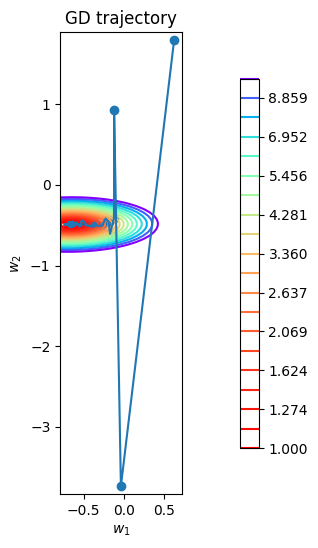

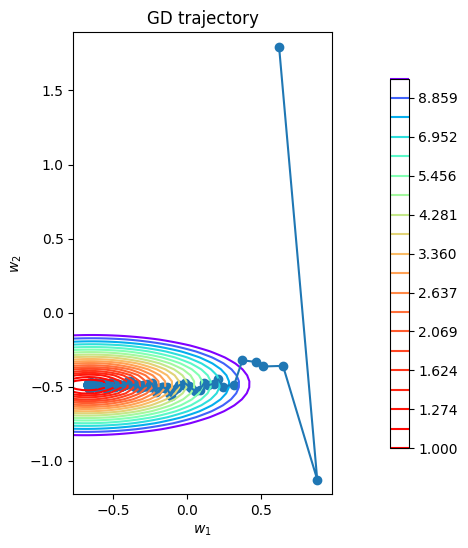

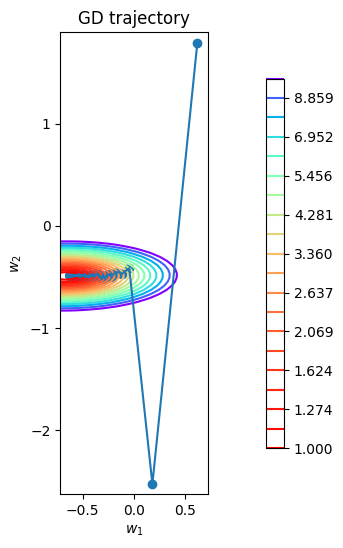

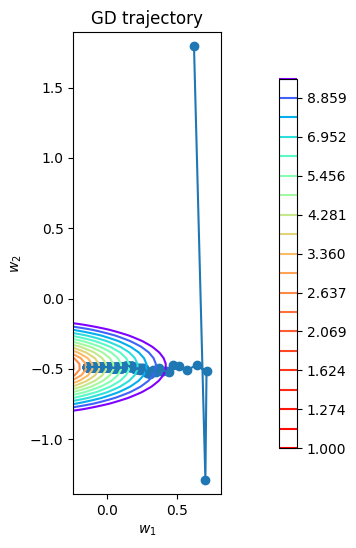

In [236]:
lr, batch_size = 0.01, 10
p_list = np.linspace(0.1, 1, 5)
loss = MSELoss()
for p in p_list:
    w_list = stochastic_gradient_descent_with_decay(w_init, X, y, loss, lr, batch_size, p, 1000)
    plot_gd(w_list, X, y, loss)

*Чем меньше значение p, тем больше шаги. При большем значение p, шаги быстро становятся осторожными*

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

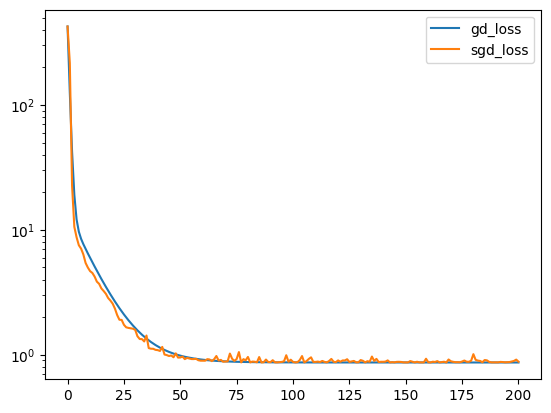

In [237]:
loss = MSELoss()
lr, batch_size, n_iterations = 0.003, 10, 200

gd_w_list = gradient_descent(w_init, X, y, loss, lr, n_iterations)
sgd_w_list  = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, n_iterations)

gd_loss_list = [loss.calc_loss(X, y, w) for w in gd_w_list]
sgd_loss_list = [loss.calc_loss(X, y, w) for w in sgd_w_list]

plt.plot(gd_loss_list, label="gd_loss")
plt.plot(sgd_loss_list, label="sgd_loss")
plt.yscale("log")
plt.legend()

*SGD быстрее спускается к минимуму, но имеет больший loss*

## Часть 2. Линейная регрессия (5 баллов)

Напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`. Не забывайте про единичный признак!

В методе `predict` мы будем применять нашу регрессию к датасету,

In [238]:
from sklearn.base import BaseEstimator, RegressorMixin


class LinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)

        bias_column = np.ones((X.shape[0], 1))
        X = np.hstack([X, bias_column])
        w_init = np.random.normal(-10, 10, X.shape[1])
        self.w = gradient_descent(w_init, X, y, self.loss, self.lr)[-1]
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"

        X = np.asarray(X)

        bias_column = np.ones((X.shape[0], 1))
        X = np.hstack([X, bias_column])
        return X @ self.w

    def set_params(self, **params):
        if "lr" in params:
            self.lr = params["lr"]
        self.loss.set_params(**params)
        return self

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [239]:
MSE_linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [240]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [241]:
y = X_raw[25]
X_raw = X_raw.drop([25, "index"], axis=1)

Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [242]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)

numeric_features = X_raw.select_dtypes([np.number]).columns
X_train[numeric_features] = X_train[numeric_features].fillna(X_train[numeric_features].mean())
X_test[numeric_features] = X_test[numeric_features].fillna(X_train[numeric_features].mean())

categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False), categorical), ("scaling", StandardScaler(), numeric_features)]
)

MSE_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", MSE_linear_regression)])

Обучите линейную регрессию на обучающей выборке

In [243]:
model = MSE_pipeline.fit(X_train, y_train)

Для оценки качества реализуем `r2_score`, который является нормализацией `mean_square_error`.

In [244]:
def r2(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    ss_res = np.sum((y_true - y_predicted) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2_score = 1 - (ss_res / ss_tot)
    
    return r2_score

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке.

In [245]:
import warnings
warnings.filterwarnings('ignore')

In [246]:
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

print(f"R2-score train: {r2(y_train, y_train_predicted)}")
print(f"R2-score test: {r2(y_test, y_test_predicted)}")

R2-score train: 0.9722358535217617
R2-score test: 0.9059696773113236


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак).

**Вопрос**: надо ли регуляризовывать bias?

**Ответ**: нет. Большой bias не обозначает переобучение (предсказывая цены на квартиры bias будет большим т.к. цены на квартиры большие)

Не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [247]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return ((X @ w - y) ** 2).mean() + self.coef * (w[:-1]) ** 2

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        w_no_bias = w.copy()
        w_no_bias[-1] = 0
        return (2 / X.shape[0]) * X.T @ (X @ w - y) + 2 * self.coef * w_no_bias

    def set_params(self, **params):
        if "coef" in params:
            self.coef = params["coef"]
        return self

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [248]:
mse2loss_linear_regression = LinearRegression(MSEL2Loss(0.1))

Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [249]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from sklearn.model_selection import GridSearchCV

lrs = np.logspace(-5, -1, 30)
coefs = np.logspace(-5, -1, 30)

mse2loss_searcher_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", mse2loss_linear_regression)])

searcher_lr = GridSearchCV(
    mse2loss_searcher_pipeline, [{"regression__lr": lrs}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1
)

searcher_lr.fit(X_train, y_train)
best_lr = searcher_lr.best_params_["regression__lr"]

mse2loss_searcher_coef_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(MSEL2Loss(0.1), best_lr))])

searcher_coef = GridSearchCV(
    mse2loss_searcher_pipeline, [{"regression__coef": coefs}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1
)
searcher_coef.fit(X_train, y_train)
best_coef = searcher_coef.best_params_["regression__coef"]
print("Best lr = %.5f" % best_lr)
print("Best coef = %.5f" % best_coef)

In [271]:
best_lr = 0.10000
best_coef = 0.01487

In [272]:
mse2loss_linear_regression = LinearRegression(MSEL2Loss(best_coef), best_lr)
mse2loss_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", mse2loss_linear_regression)])
mse2loss_model = mse2loss_pipeline.fit(X_train, y_train)

In [273]:
y_train_predicted = mse2loss_model.predict(X_train)
y_test_predicted = mse2loss_model.predict(X_test)

print(f"R2-score train: {r2(y_train, y_train_predicted)}")
print(f"R2-score test: {r2(y_test, y_test_predicted)}")

R2-score train: 0.9481861529766926
R2-score test: 0.9133445466525246


*Метрики на тестовой выборке стали лучше. Так же разница между скором на тренировочной и тестовой выборках стала меньше*

В нашем датасете могут быть выбросы, с ними хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [277]:
class HuberLoss(BaseLoss, BaseEstimator):
    def __init__(self, eps: float) -> None:
        self.eps = eps
   
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        z = X @ w - y
        return np.mean(np.where(np.abs(z) < self.eps, (z ** 2) / 2, self.eps * (np.abs(z) - self.eps / 2)))
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        z_list = X @ w - y
        phi_grad_val = np.array([z if z < abs(self.eps) else self.eps * np.sign(z)  for z in z_list])

        return X.T @ phi_grad_val / X.shape[0]
       
    def set_params(self, **params):
        if "eps" in params:
            self.eps = params["eps"]
        return self

Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [270]:
huber_loss_regression = LinearRegression(HuberLoss(1000))

In [ ]:
from sklearn.model_selection import GridSearchCV

lrs = np.logspace(-5, -1, 30)
eps_list = np.logspace(2, 5, 30)

MSEL2Loss_searcher_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", huber_loss_regression)])

searcher_lr = GridSearchCV(
    MSEL2Loss_searcher_pipeline, [{"regression__lr": lrs}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1
)

searcher_lr.fit(X_train, y_train)
best_lr = searcher_lr.best_params_["regression__lr"]

MSEL2Loss_searcher_coef_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(HuberLoss(1000), best_lr))])

searcher_coef = GridSearchCV(
    MSEL2Loss_searcher_pipeline, [{"regression__eps": eps_list}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1
)
searcher_coef.fit(X_train, y_train)
best_eps = searcher_coef.best_params_["regression__eps"]
print("Best lr = %.5f" % best_lr)
print("Best eps = %.5f" % best_eps)

In [278]:
best_lr = 0.00117
best_eps = 2395.266

In [279]:
huber_linear_regression = LinearRegression(HuberLoss(best_eps), best_lr)
huber_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", huber_linear_regression)])
huber_model = huber_pipeline.fit(X_train, y_train)

In [280]:
y_train_predicted = MSEL2_model.predict(X_train)
y_test_predicted = MSEL2_model.predict(X_test)

print(f"R2-score on train: {r2(y_train, y_train_predicted)}")
print(f"R2-score on test: {r2(y_test, y_test_predicted)}")

R2-score on train: 0.9481861529766926
R2-score on test: 0.9133445466525246


Вставьте ваш любимый мем 2025 в ячейку ниже:

In [ ]:
# ========== TODO ==========
#      Ваш мем здесь       =
# ==========================